# Goal: rotate XYZ signals to vehicle reference frame

#### Experiment: I drove my car from home to Censio and back.  My phone rested on my seat facing forwards for the trip to Censio.  Nick was in the passenger seat with his phone in his pocket.  For the return trip, we swapped phones.  The total time for the trip was about 15 minutes.

In [44]:
import pandas as pd
%matplotlib inline

In [45]:
# load the raw data
df = pd.read_csv('../Data/shaneiphone_exp2.csv')

#### The XYZ axes from SensorLog are in the frame of the iPhone.  On the way to Censio, my phone was placed flat on the driver seat.  On the return trip Nick had my phone in his pocket at a slight angle. This is reflected in the step function like behavior of the gravityXYZ time series.  

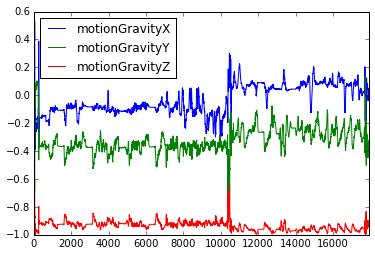

In [46]:
# plot gravity signal
df[['motionGravityX', 'motionGravityY', 'motionGravityZ']].plot()

#### This step function like behavior is present in the accelerometer and gyroscope XYZ signals.  My phone was on the driver side for the trip out and on the passenger side for the return trip. Machine learning classifiers will pick up on this signal and classify driver vs. passenger side simply based on phone orientation.  This will generalize poorly, since there is no reason to expect that phones placed on a particular side of a vehicle will have a given orientation.  Therefore, the reference frame needs to be adjusted to match that of the vehicle. This can be done using quaternions.

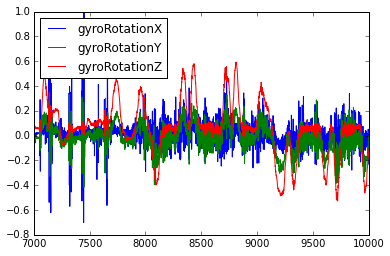

In [47]:
# plot gyroscope signal [indices 7000 to 10000 include a series of sharp turns in the Censio parking lot]
df[7000:10000][['gyroRotationX', 'gyroRotationY', 'gyroRotationZ']].plot()

#### If the reference frame was that of the vehicle instead of the phone, only gyroRotationZ should trace turns.

#### SensorLog provides a quaternion for every point in time, so rotating the XYZ signals to the vehicle reference frame is straightforward (see quatrotate.py)

In [48]:
from quatrotate import qv_mult # this routine implements rotation via quaternion multiplication
import numpy as np

def getrot(quatern, vector):
    rotatedvector = []
    for i in range(vector.shape[0]):
        rotatedvector.append(qv_mult(tuple(quatern[i, :]), 
            tuple(vector[i, :])))
    return np.array(rotatedvector)

In [49]:
def rotate(df):

    """ Generate rdf, a rotated version of df where the z-axis is aligned
    with gravity. """

    varlist = ['accelerometerAcceleration', 'motionUserAcceleration',
            'motionGravity', 'motionMagneticField', 'gyroRotation']

    quaternion = df[['motionQuaternionW', 'motionQuaternionX', 
        'motionQuaternionY', 'motionQuaternionZ']].values

    for ivar in varlist:
        print("..." + ivar)
        xyzlist = [ivar + 'X', ivar + 'Y', ivar + 'Z']
        xyz = df[xyzlist].values
        xyz_rotated = getrot(quaternion, xyz)
        df[ivar + 'X'] = xyz_rotated[:, 0]
        df[ivar + 'Y'] = xyz_rotated[:, 1]
        df[ivar + 'Z'] = xyz_rotated[:, 2]


In [50]:
# rotate does an in-place rotation
rdf = df.copy()
rotate(rdf)

...accelerometerAcceleration
...motionUserAcceleration
...motionGravity
...motionMagneticField
...gyroRotation


#### Now let's investigate the rotated XYZ signals

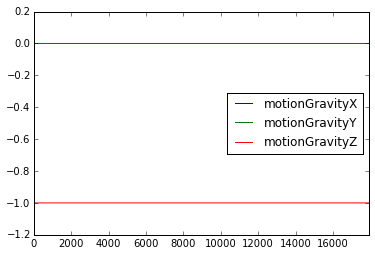

In [51]:
rdf[['motionGravityX', 'motionGravityY', 'motionGravityZ']].plot()

#### Nice, GravityZ = -1 and GravityX = GravityY = 0

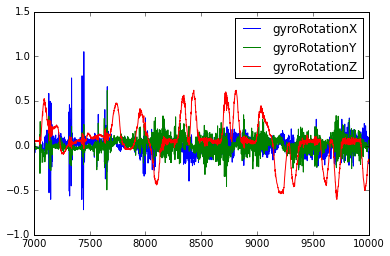

In [52]:
# indices 7000 to 10000 include a series of sharp turns in the Censio parking lot
rdf[7000:10000][['gyroRotationX', 'gyroRotationY', 'gyroRotationZ']].plot()

#### Also nice: gyroRotationY and gyroRotationX show no significant change during a left or right turn